In [1]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append('../..')

In [2]:
from collections import defaultdict
import json

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import adjusted_rand_score

In [3]:
from pygraphs.graphs.generator import StochasticBlockModel
from pygraphs.measure import kernels
from pygraphs.cluster import KKMeans
from pygraphs.scenario import ParallelByGraphs

# Experiment 1
Calc a 2d field p_in vs p_out for several n and k (balanced classes)

$$
n = 50, 100, 150, 200 \\
k = 2, 3, 4, 5, 10 \\
p_{in}, p_{out} \in (0, 1] \text{ with step}=0.05
$$

mean (or median) by 100 graphs

In [4]:
kernel_colors = dict([(k.name, i) for i, k in enumerate(kernels)])

In [5]:
class CellMeasureResults:
    def __init__(self, name, params, ari, error):
        self.measure_name = name
        self.params = params
        self.ari = ari
        self.error = error
    
    def mari(self, method='max'):
        if len(self.ari) == 0:
            return 0
        elif method == 'max':
            return np.nanmax(self.ari)
        elif method == 'mean':
            return np.nanmean(self.ari)
        elif method == 'median':
            return np.nanmedian(self.ari)


class PictureCellResults:
    def __init__(self):
        self.measure_results = {}
    
    def best_measure(self):
        measure_results_list = [(measure_name, measure_result.mari(method='max')) \
                                for measure_name, measure_result in self.measure_results.items()]
        measure_results_list = sorted(measure_results_list, key=lambda x: x[1], reverse=True)
        return measure_results_list[0]  # tuple (name, ari)
    

class PictureResults:
    def __init__(self, name, n_pin, n_pout):
        self.name = name
        self.results = [[PictureCellResults() for _ in range(n_pout)] for _ in range(n_pin)]
        
    def best_measure_map(self, kernel_colors):
        measure_map = np.full((len(self.results), len(self.results[0])), np.nan)
        ari_map = np.full((len(self.results), len(self.results[0])), np.nan)
        for i in range(len(self.results)):
            for j in range(len(self.results[0])):
                name, ari = self.results[i][j].best_measure()
                measure_map[i, j] = kernel_colors[name]
                ari_map[i, j] = ari 
        return measure_map, ari_map

In [6]:
ns = [100]
ks = [2]
estimators = [KKMeans]
step = 0.05
p_ins = np.arange(0.0, 1.0001, step)
p_outs = np.arange(0.0, 1.0001, step)

overall_results = {}

classic_plot = ParallelByGraphs(adjusted_rand_score, np.linspace(0, 1, 31), progressbar=False)
for n, k, estimator in product(ns, ks, estimators):  # one picture
    experiment_name = f'{n}_{k}_{estimator.name}'
    picture_results = PictureResults(experiment_name, p_ins.shape[0], p_outs.shape[0])
    overall_results[experiment_name] = picture_results
    for p_in, p_out in tqdm(list(product(p_ins, p_outs)), desc=experiment_name):  # one pixel
        p_in_idx, p_out_idx = int(p_in / step), int(p_out / step)
        cell_results = picture_results.results[p_in_idx][p_out_idx]
        graphs, info = StochasticBlockModel(n, k, p_in=p_in, p_out=p_out).generate_graphs(100)
        for kernel in kernels:
            try:
                params, ari, error = classic_plot.perform(estimator, kernel, graphs, k, n_jobs=12)
            except KeyboardInterrupt:
                exit(1)
            except:
                print(f'{p_in}, {p_out}, {kernel.name} -- error')
                params, ari, error = [], [], []
            cell_results.measure_results[kernel.name] = CellMeasureResults(kernel.name, params, ari, error)            

0.0, 0.0, NHeat -- error
0.0, 0.0, logNHeat -- error
0.0, 0.0, SCCT -- error
0.0, 0.0, PPR -- error
0.0, 0.0, logPPR -- error
0.0, 0.0, HeatPPR -- error
0.0, 0.0, logHeatPPR -- error
0.0, 0.05, NHeat -- error
0.0, 0.05, logNHeat -- error
0.0, 0.05, SCCT -- error
0.0, 0.05, PPR -- error
0.0, 0.05, logPPR -- error
0.0, 0.05, HeatPPR -- error
0.0, 0.05, logHeatPPR -- error
0.0, 0.1, NHeat -- error
0.0, 0.1, logNHeat -- error
0.0, 0.1, SCCT -- error
0.0, 0.1, PPR -- error
0.0, 0.1, logPPR -- error
0.0, 0.1, HeatPPR -- error
0.0, 0.1, logHeatPPR -- error
0.0, 0.15000000000000002, NHeat -- error
0.0, 0.15000000000000002, logNHeat -- error
0.0, 0.15000000000000002, SCCT -- error
0.0, 0.15000000000000002, PPR -- error
0.0, 0.15000000000000002, logPPR -- error
0.0, 0.15000000000000002, HeatPPR -- error
0.0, 0.15000000000000002, logHeatPPR -- error
0.05, 0.0, NHeat -- error
0.05, 0.0, logNHeat -- error
0.05, 0.0, SCCT -- error
0.05, 0.0, PPR -- error
0.05, 0.0, logPPR -- error
0.05, 0.0, HeatPPR

In [22]:
for cell_x, content_x in enumerate(overall_results['100_2_KernelKMeans'].results):
    for cell_y, content_xy in enumerate(content_x):
        for measure_name, content_xy_measure in content_xy.measure_results.items():
            if len(content_xy_measure.ari) == 0:
                print(cell_x, cell_y, measure_name)
                content_xy_measure.ari = [0]

0 0 pWalk
0 0 Walk
0 0 logFor
0 0 logComm
0 0 logHeat
0 0 NHeat
0 0 logNHeat
0 0 SCT
0 0 SCCT
0 0 RSP
0 0 FE
0 0 PPR
0 0 logPPR
0 0 ModifPPR
0 0 logModifPPR
0 0 HeatPPR
0 0 logHeatPPR
0 0 SP-CT
0 1 Walk
0 1 logComm
0 1 logHeat
0 1 NHeat
0 1 logNHeat
0 1 SCCT
0 1 RSP
0 1 FE
0 1 PPR
0 1 logPPR
0 1 ModifPPR
0 1 logModifPPR
0 1 HeatPPR
0 1 logHeatPPR
0 1 SP-CT
0 2 NHeat
0 2 logNHeat
0 2 SCCT
0 2 PPR
0 2 logPPR
0 2 HeatPPR
0 2 logHeatPPR
0 3 NHeat
0 3 logNHeat
0 3 SCCT
0 3 PPR
0 3 logPPR
0 3 HeatPPR
0 3 logHeatPPR
1 0 Walk
1 0 logFor
1 0 logComm
1 0 logHeat
1 0 NHeat
1 0 logNHeat
1 0 SCCT
1 0 RSP
1 0 FE
1 0 PPR
1 0 logPPR
1 0 ModifPPR
1 0 logModifPPR
1 0 HeatPPR
1 0 logHeatPPR
1 0 SP-CT
1 1 NHeat
1 1 logNHeat
1 1 SCCT
1 1 PPR
1 1 logPPR
1 1 HeatPPR
1 1 logHeatPPR
1 2 NHeat
1 2 logNHeat
1 2 SCCT
1 2 PPR
1 2 logPPR
1 2 HeatPPR
1 2 logHeatPPR
2 0 Walk
2 0 logFor
2 0 logComm
2 0 logHeat
2 0 NHeat
2 0 logNHeat
2 0 SCCT
2 0 RSP
2 0 FE
2 0 PPR
2 0 logPPR
2 0 logModifPPR
2 0 HeatPPR
2 0 logHeatPPR


Text(0, 0.5, '$p_{out}$')

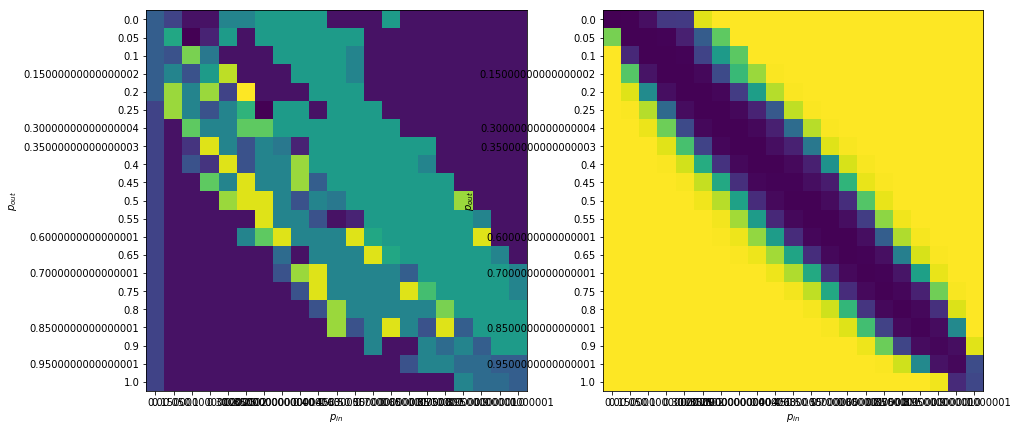

In [23]:
colors, ari = overall_results['100_2_KernelKMeans'].best_measure_map(kernel_colors)

fig, ax = plt.subplots(1, 2, figsize=(15, 15))

ax[0].imshow(colors)
ax[0].set_xticks(range(p_ins.shape[0]))
ax[0].set_yticks(range(p_outs.shape[0]))
ax[0].set_xticklabels(p_ins)
ax[0].set_yticklabels(p_outs)
ax[0].set_xlabel('$p_{in}$')
ax[0].set_ylabel('$p_{out}$')

ax[1].imshow(ari, vmin=0, vmax=1)
ax[1].set_xticks(range(p_ins.shape[0]))
ax[1].set_yticks(range(p_outs.shape[0]))
ax[1].set_xticklabels(p_ins)
ax[1].set_yticklabels(p_outs)
ax[1].set_xlabel('$p_{in}$')
ax[1].set_ylabel('$p_{out}$')

In [43]:
picture_results = overall_results['100_2_KernelKMeans']
jjson = {}
for p_in, p_out in tqdm(list(product(p_ins, p_outs)), desc=experiment_name):  # one pixel
    p_in_idx, p_out_idx = int(p_in / step), int(p_out / step)
    cell_results = picture_results.results[p_in_idx][p_out_idx]

    jcell = {}
    for measure_result in cell_results.measure_results.values():
        jcell[measure_result.measure_name] = {
            'params': measure_result.params.tolist() if type(measure_result.params) != list else [],
            'ari': measure_result.ari.tolist() if type(measure_result.ari) != list else [],
            'error': measure_result.error.tolist() if type(measure_result.error) != list else [],
        }
    jjson[f'{p_in}, {p_out}'] = jcell

In [45]:
with open('result.json', 'w') as f:
    json.dump(jjson, f, indent=4, sort_keys=True)

In [37]:
list(cell_results.measure_results.values())[10].params

array([], dtype=float64)

In [29]:
measure_result

In [41]:
type(measure_result.ari) != list

False

In [42]:
measure_result.params

[]